<a href="https://colab.research.google.com/github/richardtguy/colab/blob/main/MtG_deck_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Land in Magic: The Gathering Decks

## Problem 1

Given a deck of cards containing two types, A and B, what is the probability of drawing at least n cards of type A in a hand of m cards?

_"How many lands should I put in my deck?"_

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

NUM_ITERATIONS = 10000
nA = 16
nB = 24

def get_sample_data(n, i):
    # Return a dataframe containing i iterations of a shuffled deck of n cards
    return pd.DataFrame([random.sample(list(range(n)), n) for i in range(i)])

# Get random sample data.  Columns represent rounds in which one card is drawn, 
# rows represent successive simulations.
df = get_sample_data(nA+nB, NUM_ITERATIONS)

# Assume card type A is represented by first nA cards in the unshuffled deck.  
# Use element-wise comparison to give True if card drawn this round is type A, 
# False otherwise
df = df.lt(nA)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,True,True,True,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,True,True,False,True,False,True,True,True,False,False,False,False,True,True,False
1,False,False,True,False,False,True,True,True,False,False,True,False,False,True,True,True,True,True,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,True,True,False
2,False,False,True,True,True,True,False,False,False,True,False,False,False,True,False,False,True,True,True,False,False,True,False,False,False,False,False,False,False,False,True,True,True,False,False,True,False,False,True,True
3,True,False,False,True,True,False,True,True,False,False,True,False,False,False,False,True,False,False,False,False,True,False,True,False,True,True,False,True,True,False,True,False,False,False,False,False,True,False,True,False
4,True,False,False,False,True,False,False,True,True,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,True,False,True,True,False,True,True,False,False,False,True,True,False,True,False


In [ ]:
# Count the cumulative number of cards of type A drawn in each successive round
df = df.cumsum(axis=1)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,1,2,3,3,3,4,4,5,5,5,5,6,6,6,6,6,6,6,7,7,8,8,8,8,8,9,10,10,11,11,12,13,14,14,14,14,14,15,16,16
1,0,0,1,1,1,2,3,4,4,4,5,5,5,6,7,8,9,10,10,10,11,11,11,12,12,12,13,13,13,13,13,13,13,13,14,14,14,15,16,16
2,0,0,1,2,3,4,4,4,4,5,5,5,5,6,6,6,7,8,9,9,9,10,10,10,10,10,10,10,10,10,11,12,13,13,13,14,14,14,15,16
3,1,1,1,2,3,3,4,5,5,5,6,6,6,6,6,7,7,7,7,7,8,8,9,9,10,11,11,12,13,13,14,14,14,14,14,14,15,15,16,16
4,1,1,1,1,2,2,2,3,4,5,5,5,6,6,6,6,7,7,7,7,7,7,7,7,8,9,9,10,11,11,12,13,13,13,13,14,15,15,16,16


In [ ]:
# Calculate probability (%) of drawing more than i cards of type A by each round
d = []
for i in range(6):
    s = df.gt(i)
    d.append(s[s].count())
res = (pd.DataFrame(d)/NUM_ITERATIONS)*100
res

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,40.33,64.90,79.55,88.13,93.38,96.53,98.19,99.04,99.55,99.82,99.95,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1,0.00,15.42,35.36,52.88,67.95,78.78,86.72,92.10,95.40,97.50,98.69,99.30,99.59,99.81,99.91,99.98,99.99,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
2,0.00,0.00,5.92,17.07,31.22,45.59,59.30,71.15,80.27,87.30,92.41,95.48,97.25,98.40,99.19,99.61,99.86,99.97,99.99,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
3,0.00,0.00,0.00,1.99,7.37,16.33,27.36,39.22,52.10,63.78,73.93,82.04,88.49,92.58,95.58,97.44,98.63,99.34,99.73,99.89,99.94,99.98,99.99,100.00,100.00,100.00,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
4,0.00,0.00,0.00,0.00,0.73,3.03,7.63,14.42,23.80,34.70,46.39,57.89,68.08,77.11,84.07,89.68,93.68,96.05,97.74,98.81,99.47,99.74,99.91,99.97,99.99,100.00,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
5,0.00,0.00,0.00,0.00,0.00,0.19,1.16,3.47,7.18,12.90,21.20,30.51,41.45,52.57,63.24,72.40,80.37,86.67,91.50,94.67,96.94,98.53,99.35,99.68,99.88,99.97,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


In [ ]:
# filter and rename columns for initial hand (0) and subsequent turns
data = res.filter(items=[6, 7, 8, 9, 10, 11, 12])
data = data.rename(columns=lambda x: x-6).rename(index=lambda x: ">="+str(x+1))
data

,0,1,2,3,4,5,6
>=1,98.19,99.04,99.55,99.82,99.95,100.00,100.00
>=2,86.72,92.10,95.40,97.50,98.69,99.30,99.59
>=3,59.30,71.15,80.27,87.30,92.41,95.48,97.25
>=4,27.36,39.22,52.10,63.78,73.93,82.04,88.49
>=5,7.63,14.42,23.80,34.70,46.39,57.89,68.08
>=6,1.16,3.47,7.18,12.90,21.20,30.51,41.45


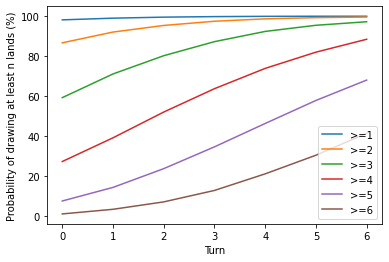

In [ ]:
my_plot = data.transpose().plot(kind='line')
my_plot.set_xlabel("Turn")
my_plot.set_ylabel("Probability of drawing at least n lands (%)")
start, end = my_plot.get_xlim()
ticks = my_plot.xaxis.set_ticks(np.arange(0, end, 1))

## Key Results
- For a typical deck with 40% land, there is a 74% chance of being able to cast a card with CMC=4 on turn 4 (for a single colour deck, or ignoring colours).
- Decreasing the land to 35% reduce this to 65%; increasing to 45% increases the probabilty to 80%
- Note that it is important to consider that lands drawn later in the game may be effectively wasted, so the goal is to identify the minimum number of lands that gives a good probability of being able to cast spells in the early and mid-game.

## Problem 2

Given a deck of cards containing three types, A, B and C, what is the probability of drawing at least i cards of type A, and j cards of type A or B, in a hand of n cards?

_"How many of a particular land type should I put in my multi-coloured deck?"_

In [ ]:
def analyse(df, nA, nB, nC):
    """
    Return a dictionary of result dataframes, where key is the number of land type A required, i
    Result dataframes:
        Cells = prob of drawing i cards of type A, and j cards of type A or B by turn x
        Rows = total number of lands required (A+B)
        Cols = turn, x
    """
    
    # Element-wise comparison: True if card drawn this round is type A/B, False otherwise
    dfA = df.lt(nA)
    dfB = df.lt(nB)
    # Count cumulative cards of type A and B drawn by each round
    dfA = dfA.cumsum(axis=1)
    dfB = dfB.cumsum(axis=1)

    # Calculate probability (%) of drawing at least i cards of type A and at least j cards of type A or B by round m
    # ...for i = 0 to 4, and j = 0 to 6
    # i = 1
    ret = {}
    for i in range(5):
        sA = dfA.ge(i)
        d = []
        for n in range(7):
            sB = dfB.gt(n)
            s = sB & sA
            d.append(s[s].count())
        res = (pd.DataFrame(d)/len(df.index))*100
        data = res.filter(items=[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
        ret[i] = data.rename(columns=lambda x: x-6).rename(index=lambda x: ">="+str(x+1))

    return ret

In [ ]:
A = 5 # e.g. Swamps
B = 16 # total lands
C = 24 # total cards

df = get_sample_data(40, NUM_ITERATIONS)
res = analyse(df, A, B, C)

# results for e.g. {C}{X} (i.e. one mana of a specific colour, and one colourless mana)
res[1]

,0,1,2,3,4,5,6,7,8,9,10
>=1,64.65,69.92,74.52,78.63,82.25,85.47,88.19,90.33,92.24,93.80,95.15
>=2,60.90,67.53,73.02,77.88,81.85,85.24,88.12,90.29,92.22,93.79,95.14
>=3,46.15,56.24,65.11,72.22,78.24,82.96,86.70,89.54,91.74,93.62,95.10
>=4,23.77,34.74,45.75,56.25,65.82,73.67,80.22,85.37,89.30,91.92,94.08
>=5,7.25,14.17,22.49,32.27,43.08,54.22,64.11,72.41,79.82,85.61,89.87
>=6,1.08,3.02,6.95,12.69,19.96,29.53,39.95,50.72,61.04,70.18,78.04
>=7,0.09,0.40,1.07,3.11,6.49,11.30,18.03,26.32,36.45,47.13,56.89


In [ ]:
# results for e.g. {C}{C}{X}
res[2]

,0,1,2,3,4,5,6,7,8,9,10
>=1,20.38,25.61,30.76,36.37,41.93,47.42,53.12,58.10,63.13,67.76,72.02
>=2,20.38,25.61,30.76,36.37,41.93,47.42,53.12,58.10,63.13,67.76,72.02
>=3,18.14,23.96,29.64,35.49,41.37,47.12,52.93,58.02,63.08,67.74,72.01
>=4,11.50,17.52,23.72,30.83,37.68,44.31,50.94,56.77,62.32,67.30,71.80
>=5,4.36,8.61,13.71,20.17,27.52,35.72,43.79,51.17,58.20,64.72,70.06
>=6,0.75,2.18,4.89,9.20,14.79,21.72,30.02,39.02,47.38,55.75,63.39
>=7,0.04,0.31,0.83,2.49,5.27,9.31,15.04,21.96,30.53,40.06,48.74


In [ ]:
# plot probability of being able to play a card with specified CMC, e.g. 4, including either 1 or 2 coloured mana 
# by a given turn, e.g. 4, for different numbers of land of a certain type in the deck (assuming total land = 40%)

# rows = number of coloured mana in casting cost, columns = number of relevant land in deck

result = []
for j in range(5):
    res2 = []
    for i in range(3, 17):
        data = analyse(get_sample_data(40, NUM_ITERATIONS), i, 16, 24)
        res2.append(data[j].loc['>=4'][4]) 
    result.append(res2)
result = pd.DataFrame(result).rename(columns=lambda x: x+3)

result

,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,74.58,74.00,73.40,73.86,74.11,73.60,74.42,73.87,73.76,73.96,73.82,75.07,74.14,73.58
1,52.09,59.80,65.72,68.84,70.85,71.97,73.85,73.82,73.53,73.43,74.55,74.23,74.07,74.54
2,16.27,27.71,38.08,47.05,55.15,62.09,65.97,69.87,71.48,72.44,73.59,73.36,73.87,73.92
3,1.70,5.35,11.28,18.96,27.19,36.28,45.00,53.45,59.54,65.43,69.74,72.89,73.66,74.09
4,0.00,0.30,1.68,3.86,7.54,12.21,18.99,26.64,33.67,42.49,52.27,59.22,67.13,73.21


## Key Results
    
- For a typical single colour deck with 16 lands, there is a 74% chance of being able to play a card costing 4 mana on turn 4.
- For a typical 2-colour deck with 8 lands of each type, cards with a cost including only one coloured mana have a high chance of being able to be cast.  E.g. for a {R}{3} card, there is a very similar (73%) probability of being able to cast it by turn 4.
- Cards requiring two coloured mana are more risky - in the same deck as above there is a 61% chance of being able to play e.g. a {R}{R}{2} card on turn 4.
- 2-coloured mana cards in 3-colour decks are riskier still.  With only 5/6 lands of each type (16 in total) in the deck, there is only a 37%/48% chance of being able to play the same card.  If the card costs only {R}{3}, the probability increases to 66%/69%.

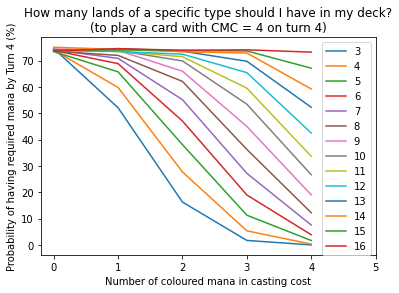

In [ ]:
my_plot2 = result.plot(kind='line')
my_plot2.set_xlabel("Number of coloured mana in casting cost")
my_plot2.set_ylabel("Probability of having required mana by Turn 4 (%)")
my_plot2.set_title("How many lands of a specific type should I have in my deck?\n(to play a card with CMC = 4 on turn 4)")
start, end = my_plot.get_xlim()
ticks = my_plot2.xaxis.set_ticks(np.arange(0, end-1, 1))